In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models.neurlux import NeurLuxModel
from nebula.models.quovadis import QuoVadisModel
from nebula.models import TransformerEncoderChunks
from nebula.constants import SPEAKEASY_LABELMAP
REVERSE_SPEAKEASY_LABELMAP = {v: k for k, v in SPEAKEASY_LABELMAP.items()}
from collections import defaultdict
import numpy as np
import pickle
import json
import torch

RUN_TYPES = ["nebula", "neurlux", "quovadis"]
RUN_NAME = "speakeasy"

INFOLDER = "out_speakeasy_multiclass"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

NEBULA_VOCAB = 50000
NEURLUX_VOCAB = 10000
QUO_VADIS_VOCAB = 600
SEQ_LEN = 512
LIMIT = "full"
# TBD -- see:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [2]:
models = defaultdict(dict)

neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_{RUN_NAME}_vocab_{NEURLUX_VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{NEURLUX_VOCAB}.json")
quo_vadis_data_folder = os.path.join(INFOLDER, f"quovadis_{RUN_NAME}_vocab_{QUO_VADIS_VOCAB}_seqlen_{SEQ_LEN}")
quo_vadis_vocab_name = [x for x in os.listdir(quo_vadis_data_folder) if x.startswith("vocab")][0]
quovadis_vocab_file = os.path.join(quo_vadis_data_folder, quo_vadis_vocab_name)
nebula_vocab_file = os.path.join(INFOLDER, f"nebula_{RUN_NAME}_vocab_{NEBULA_VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{NEBULA_VOCAB}_vocab.json")

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
    "num_classes": 8
}

models['quovadis']['class'] = QuoVadisModel
models['quovadis']['config'] = {
    "vocab": quovadis_vocab_file,
    "seq_len": SEQ_LEN,
    "num_classes": 8
}

with open(nebula_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula']['class'] = TransformerEncoderChunks
models['nebula']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": 8, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    print(f"[*] In process: {key}")

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        folder = os.path.join(INFOLDER, folder)
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_SPEAKEASY_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        #pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

[*] In process: nebula
[*] Running ROC for split: 0
Evaluating nebula_split_0 | Size: 5397768...


100%|██████████| 265/265 [00:07<00:00, 35.78it/s]


[*] Running ROC for split: 1
Evaluating nebula_split_1 | Size: 5397768...


100%|██████████| 265/265 [00:06<00:00, 38.50it/s]


[*] Running ROC for split: 2
Evaluating nebula_split_2 | Size: 5397768...


100%|██████████| 265/265 [00:06<00:00, 38.80it/s]


[*] In process: neurlux
[*] Running ROC for split: 0
Evaluating neurlux_split_0 | Size: 2794822...


100%|██████████| 265/265 [00:03<00:00, 71.15it/s] 


[*] Running ROC for split: 1
Evaluating neurlux_split_1 | Size: 2794822...


100%|██████████| 265/265 [00:02<00:00, 95.41it/s] 


[*] Running ROC for split: 2
Evaluating neurlux_split_2 | Size: 2794822...


100%|██████████| 265/265 [00:02<00:00, 97.26it/s]


[*] In process: quovadis
[*] Running ROC for split: 0
Evaluating quovadis_split_0 | Size: 1449352...


100%|██████████| 265/265 [00:03<00:00, 82.56it/s]


[*] Running ROC for split: 1
Evaluating quovadis_split_1 | Size: 1449352...


100%|██████████| 265/265 [00:03<00:00, 82.07it/s]


[*] Running ROC for split: 2
Evaluating quovadis_split_2 | Size: 1449352...


100%|██████████| 265/265 [00:03<00:00, 82.11it/s]


clean
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.004443  0.972682  0.961038  0.967288   0.954890  0.974582
neurlux   0.003486  0.975635  0.960859  0.979979   0.942521  0.974109
quovadis  0.004605  0.958050  0.946272  0.936779   0.956065  0.965531
backdoor
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.014026  0.920604  0.895593  0.849089   0.949501  0.971337
neurlux   0.036178  0.922327  0.892895  0.854517   0.945415  0.970404
quovadis  0.022537  0.892371  0.871144  0.788416   0.973434  0.966122
coinminer
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.015514  0.936543  0.906903  0.879008   0.936797  0.983659
neurlux   0.038378  0.944493  0.922978  0.893131   0.956921  0.986549
quovadis  0.008587  0.928786  0.881135  0.867683   0.895225  0.978825
dropper
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.004227  0.947693  0.874934  0.917159   0.8365

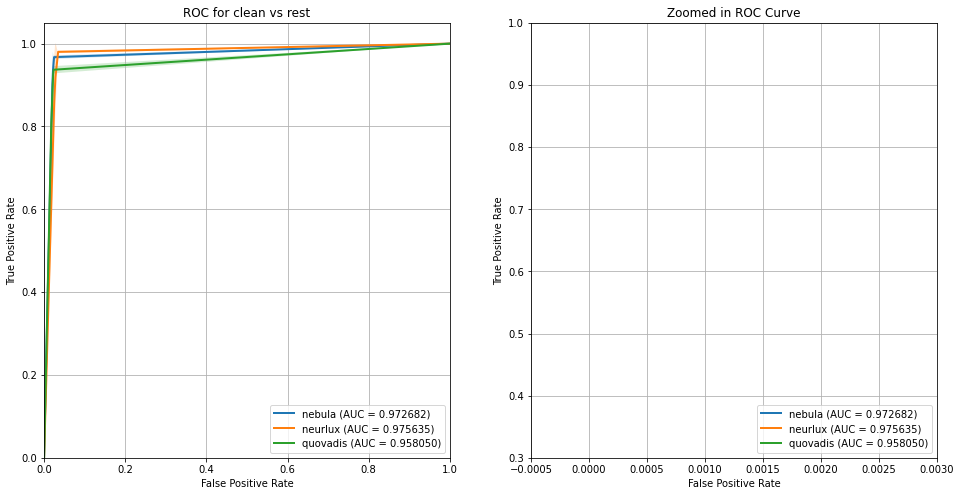

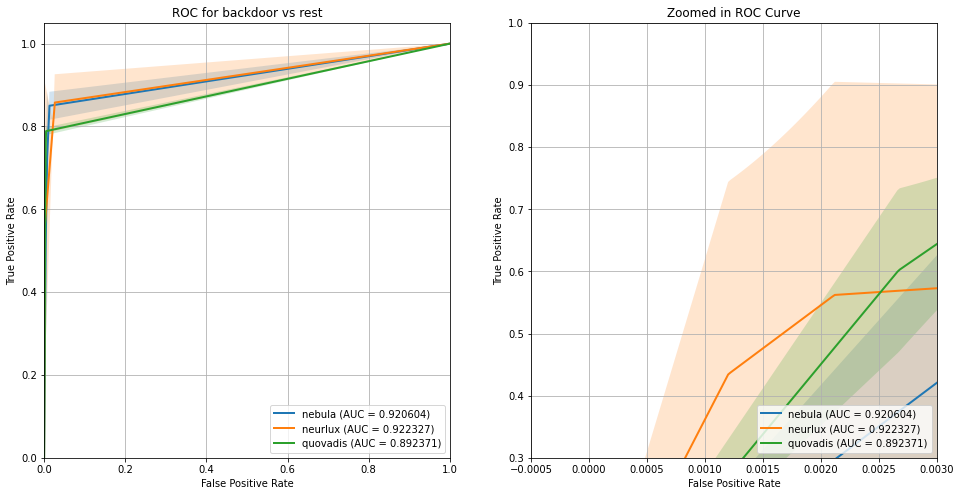

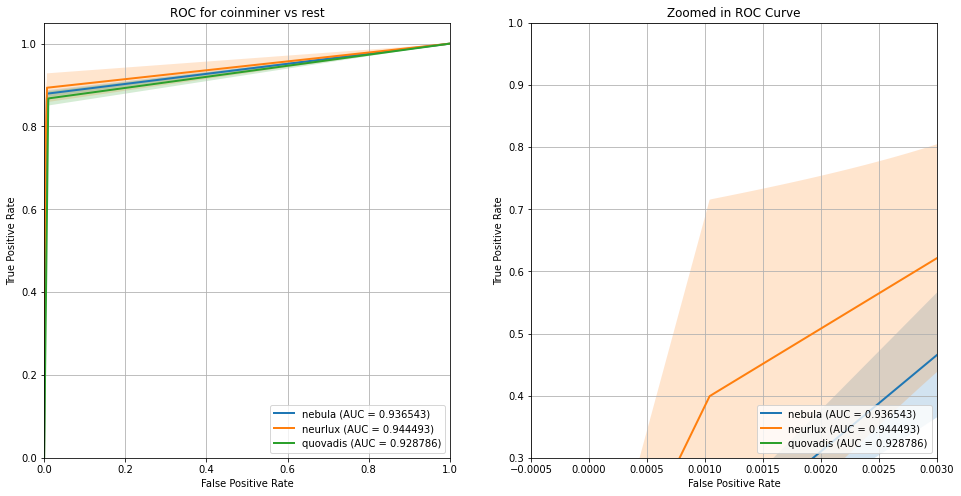

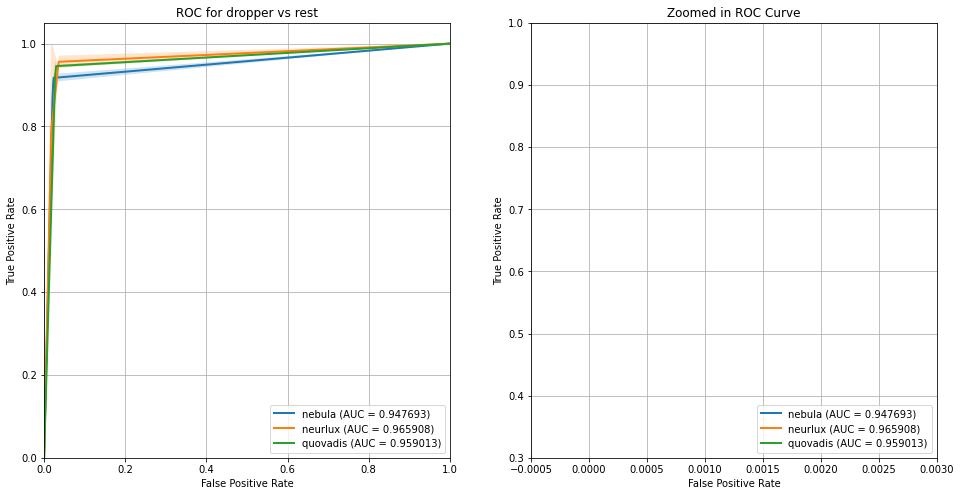

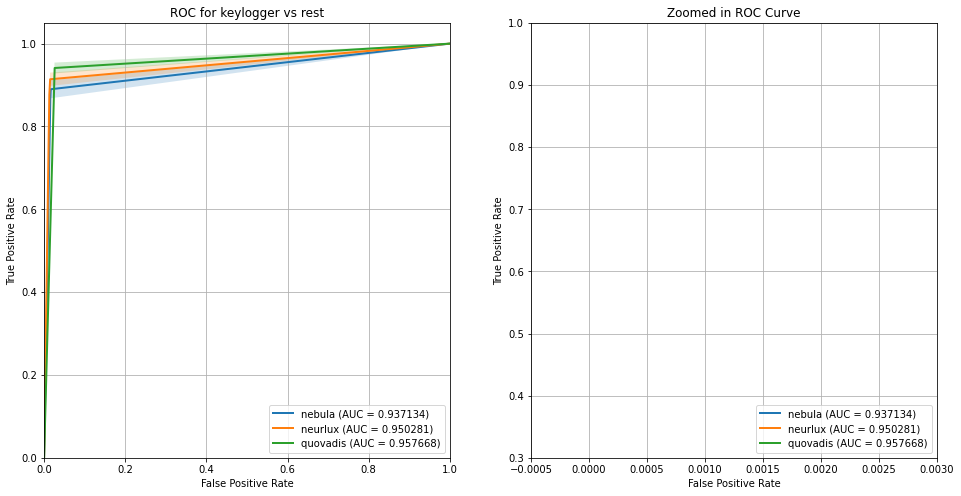

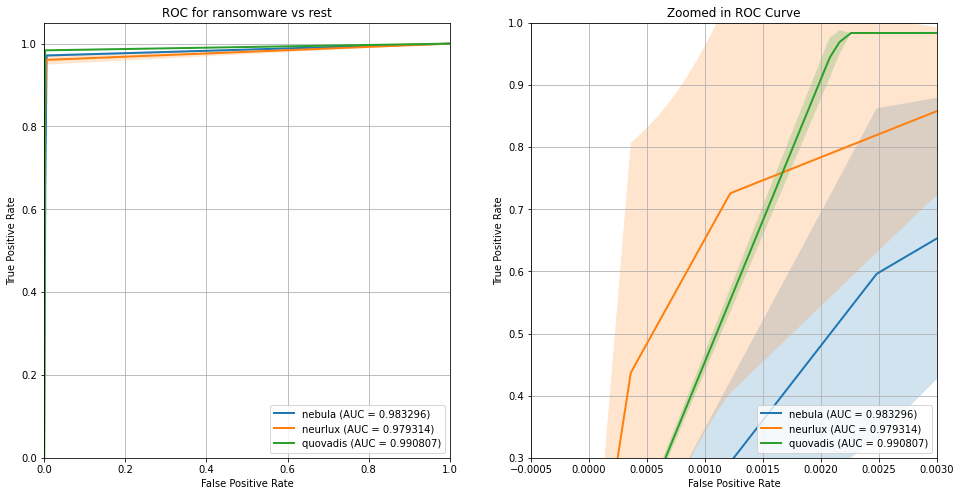

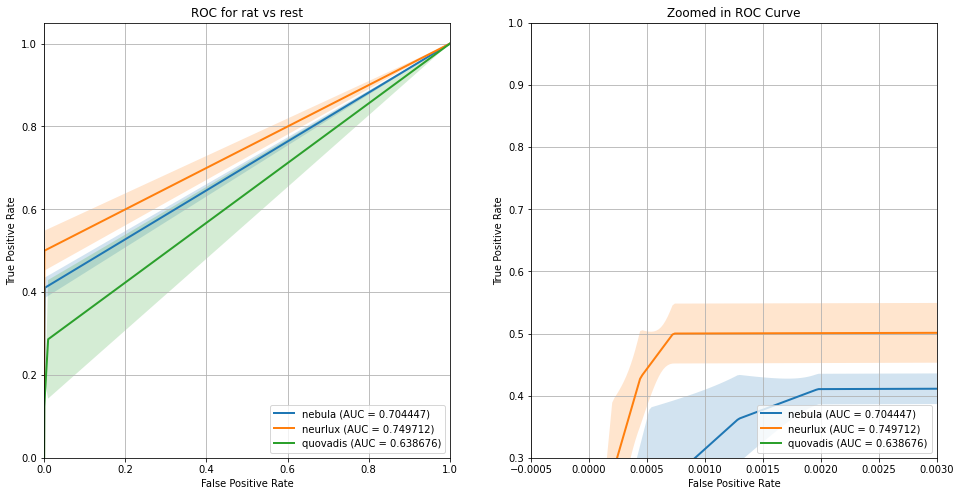

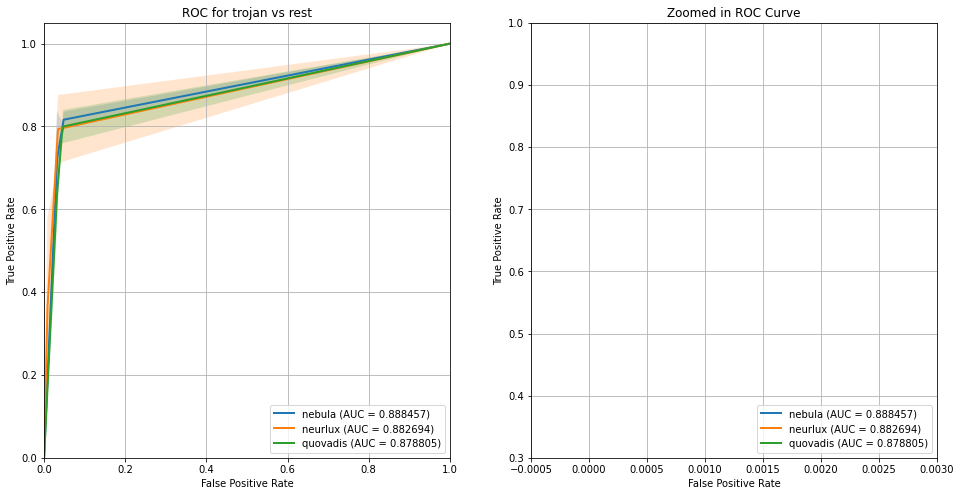

In [4]:
for selected_label in SPEAKEASY_LABELMAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_val.items()}
    base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_label)

    df, axs_val = report_alligned_metrics(
        base_fpr_val,
        tprs_mean_val,
        tprs_std_val,
        metrics_label,
        xlim=[-0.0005, 0.003],
        ylim=[0.3, 1.0],
        metrics_full=True
    )
    # suptitle to refer label
    axs_val[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])

## Test set ROCs

In [5]:
metrics_test = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = folder.split("_")[1]
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_SPEAKEASY_LABELMAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        #pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

[*] In process: nebula
[*] Running ROC for split: 0
Evaluating nebula_split_0 | Size: 5397768...


100%|██████████| 182/182 [00:04<00:00, 37.78it/s]


For class clean metrics are: fpr: [0.         0.26353292 1.        ], tpr: [0.         0.96589205 1.        ], roc_auc: 0.8511795694729472, f1: 0.8489540438148576, recall: 0.9658920539730135, precision: 0.7572729944166912, acc: 0.8419601309817889
For class backdoor metrics are: fpr: [0.         0.00536626 1.        ], tpr: [0.         0.78814433 1.        ], roc_auc: 0.8913890331193981, f1: 0.8609234234234234, recall: 0.7881443298969072, precision: 0.9485111662531017, acc: 0.9716206123973115
For class coinminer metrics are: fpr: [0.         0.01984354 1.        ], tpr: [0.         0.57304038 1.        ], roc_auc: 0.7765984193692976, f1: 0.651806822019588, recall: 0.5730403800475059, precision: 0.7556773688332028, acc: 0.9407709542138221
For class dropper metrics are: fpr: [0.         0.02722238 1.        ], tpr: [0.         0.33730159 1.        ], roc_auc: 0.6550396015785116, f1: 0.21144278606965172, recall: 0.3373015873015873, precision: 0.1539855072463768, acc: 0.9635778709714483
For

100%|██████████| 182/182 [00:04<00:00, 39.37it/s]


For class clean metrics are: fpr: [0.         0.24938849 1.        ], tpr: [0.         0.96026987 1.        ], roc_auc: 0.8554406860166642, f1: 0.8523426670363182, recall: 0.9602698650674663, precision: 0.7662247034193999, acc: 0.8470155684494743
For class backdoor metrics are: fpr: [0.         0.00478438 1.        ], tpr: [0.         0.79329897 1.        ], roc_auc: 0.8942572947125871, f1: 0.8663101604278075, recall: 0.7932989690721649, precision: 0.9541227526348419, acc: 0.9727121273051071
For class coinminer metrics are: fpr: [0.         0.01908033 1.        ], tpr: [0.         0.56353919 1.        ], roc_auc: 0.7722294321087027, f1: 0.6471189907944085, recall: 0.5635391923990499, precision: 0.7598078462770216, acc: 0.9405411616016545
For class dropper metrics are: fpr: [0.       0.019761 1.      ], tpr: [0.  0.5 1. ], roc_auc: 0.7401194986884291, f1: 0.35146443514644354, recall: 0.5, precision: 0.2709677419354839, acc: 0.973286608835526
For class keylogger metrics are: fpr: [0.    

100%|██████████| 182/182 [00:04<00:00, 38.91it/s]


For class clean metrics are: fpr: [0.         0.24205041 1.        ], tpr: [0.         0.96226887 1.        ], roc_auc: 0.860109228061711, f1: 0.8566344121899677, recall: 0.9622688655672164, precision: 0.7718981759871718, acc: 0.8518986614580342
For class backdoor metrics are: fpr: [0.         0.00885757 1.        ], tpr: [0.         0.77113402 1.        ], roc_auc: 0.8811382264468616, f1: 0.8373915477190037, recall: 0.7711340206185567, precision: 0.9161053276178812, acc: 0.9666226230826679
For class coinminer metrics are: fpr: [0.         0.03688863 1.        ], tpr: [0.         0.56413302 1.        ], roc_auc: 0.7636221910712826, f1: 0.5911636589919104, recall: 0.5641330166270784, precision: 0.6209150326797386, acc: 0.92451312690297
For class dropper metrics are: fpr: [0.         0.02652288 1.        ], tpr: [0.         0.48015873 1.        ], roc_auc: 0.7268179252658996, f1: 0.29227053140096615, recall: 0.4801587301587302, precision: 0.21006944444444445, acc: 0.9663353823174585
For 

100%|██████████| 182/182 [00:01<00:00, 103.42it/s]


For class clean metrics are: fpr: [0.         0.27884718 1.        ], tpr: [0.         0.95814593 1.        ], roc_auc: 0.8396493753017141, f1: 0.8383711396556436, recall: 0.9581459270364817, precision: 0.7452142648916529, acc: 0.8301258114551617
For class backdoor metrics are: fpr: [0.         0.00323269 1.        ], tpr: [0.         0.74175258 1.        ], roc_auc: 0.8692599441844593, f1: 0.8393117526975795, recall: 0.7417525773195877, precision: 0.9664204163868368, acc: 0.9683460676739243
For class coinminer metrics are: fpr: [0.         0.01443745 1.        ], tpr: [0.         0.57007126 1.        ], roc_auc: 0.7778169052916262, f1: 0.6687565308254964, recall: 0.5700712589073634, precision: 0.8087615838247684, acc: 0.9453668064571724
For class dropper metrics are: fpr: [0.         0.01299913 1.        ], tpr: [0.         0.62301587 1.        ], roc_auc: 0.8050083736982601, f1: 0.49683544303797467, recall: 0.623015873015873, precision: 0.4131578947368421, acc: 0.9817314873326822
For

100%|██████████| 182/182 [00:01<00:00, 102.17it/s]


For class clean metrics are: fpr: [0.         0.27959162 1.        ], tpr: [0.         0.97488756 1.        ], roc_auc: 0.8476479682630237, f1: 0.8464959861141246, recall: 0.974887556221889, precision: 0.7479869631901841, acc: 0.8374217268914804
For class backdoor metrics are: fpr: [0.         0.00452576 1.        ], tpr: [0.         0.72628866 1.        ], roc_auc: 0.8608814476314388, f1: 0.8242176074875694, recall: 0.7262886597938144, precision: 0.9526707234617985, acc: 0.9654736600218303
For class coinminer metrics are: fpr: [0.         0.01202061 1.        ], tpr: [0.         0.59619952 1.        ], roc_auc: 0.7920894590930907, f1: 0.6979492526937783, recall: 0.5961995249406176, precision: 0.8415758591785415, acc: 0.9500775550066065
For class dropper metrics are: fpr: [0.        0.0095599 1.       ], tpr: [0.         0.74206349 1.        ], roc_auc: 0.8662517984945849, f1: 0.6202321724709784, recall: 0.7420634920634921, precision: 0.5327635327635327, acc: 0.9868443729534095
For cla

100%|██████████| 182/182 [00:01<00:00, 99.32it/s] 


For class clean metrics are: fpr: [0.         0.28182495 1.        ], tpr: [0.         0.98563218 1.        ], roc_auc: 0.8519036172119194, f1: 0.850887127217818, recall: 0.985632183908046, precision: 0.7485529936426606, acc: 0.8411558568392026
For class backdoor metrics are: fpr: [0.        0.0043318 1.       ], tpr: [0.         0.74175258 1.        ], roc_auc: 0.8687103870628454, f1: 0.8351712130005804, recall: 0.7417525773195877, precision: 0.9555112881806109, acc: 0.9673694490722123
For class coinminer metrics are: fpr: [0.         0.00705972 1.        ], tpr: [0.         0.58194774 1.        ], roc_auc: 0.7874440110203624, f1: 0.7063063063063063, recall: 0.5819477434679335, precision: 0.8982584784601283, acc: 0.9531797552708681
For class dropper metrics are: fpr: [0.       0.064471 1.      ], tpr: [0.        0.6984127 1.       ], roc_auc: 0.8169708493520793, f1: 0.22946544980443284, recall: 0.6984126984126984, precision: 0.1372854914196568, acc: 0.9320962831044982
For class keylog

100%|██████████| 182/182 [00:02<00:00, 82.13it/s]


For class clean metrics are: fpr: [0.         0.26885037 1.        ], tpr: [0.         0.90954523 1.        ], roc_auc: 0.8203474302410636, f1: 0.8174264540759039, recall: 0.9095452273863068, precision: 0.7422512234910277, acc: 0.8131786063078073
For class backdoor metrics are: fpr: [0.         0.00290942 1.        ], tpr: [0.         0.75927835 1.        ], roc_auc: 0.8781844652299308, f1: 0.8519375361480624, recall: 0.7592783505154639, precision: 0.9703557312252964, acc: 0.9705865456425576
For class coinminer metrics are: fpr: [0.        0.0640463 1.       ], tpr: [0.         0.51247031 1.        ], roc_auc: 0.7242120035961056, f1: 0.4856499718626899, recall: 0.5124703087885986, precision: 0.46149732620320855, acc: 0.894984776239444
For class dropper metrics are: fpr: [0.         0.02541533 1.        ], tpr: [0.        0.5952381 1.       ], roc_auc: 0.7849113822153753, f1: 0.35799522673031026, recall: 0.5952380952380952, precision: 0.25597269624573377, acc: 0.9690928936634687
For cla

100%|██████████| 182/182 [00:02<00:00, 81.53it/s]


For class clean metrics are: fpr: [0.         0.23556312 1.        ], tpr: [0.         0.91704148 1.        ], roc_auc: 0.8407391805532946, f1: 0.8360384987755568, recall: 0.9170414792603698, precision: 0.7681841967556253, acc: 0.8346067673924283
For class backdoor metrics are: fpr: [0.         0.00924549 1.        ], tpr: [0.        0.7742268 1.       ], roc_auc: 0.8824906568623987, f1: 0.8379358437935843, recall: 0.7742268041237114, precision: 0.9130699088145897, acc: 0.9666226230826679
For class coinminer metrics are: fpr: [0.         0.05387013 1.        ], tpr: [0.         0.51425178 1.        ], roc_auc: 0.7301908274532536, f1: 0.5098616426258463, recall: 0.5142517814726841, precision: 0.5055458260361938, acc: 0.9043488251852703
For class dropper metrics are: fpr: [0.         0.02669776 1.        ], tpr: [0.         0.61111111 1.        ], roc_auc: 0.792206677677386, f1: 0.3564814814814815, recall: 0.6111111111111112, precision: 0.25163398692810457, acc: 0.9680588269087149
For cl

100%|██████████| 182/182 [00:02<00:00, 81.74it/s]


For class clean metrics are: fpr: [0.         0.19812826 1.        ], tpr: [0.         0.90704648 1.        ], roc_auc: 0.8544591099111722, f1: 0.8477842003853564, recall: 0.9070464767616192, precision: 0.7957908582703058, acc: 0.8502326650198196
For class backdoor metrics are: fpr: [0.         0.00355596 1.        ], tpr: [0.         0.78556701 1.        ], roc_auc: 0.8910055262317711, f1: 0.86615515771526, recall: 0.7855670103092783, precision: 0.9651678277390754, acc: 0.9729419199172746
For class coinminer metrics are: fpr: [0.         0.06862558 1.        ], tpr: [0.         0.50356295 1.        ], roc_auc: 0.7174686825040943, f1: 0.4696759900304625, recall: 0.503562945368171, precision: 0.44006227296315514, acc: 0.8899867869248004
For class dropper metrics are: fpr: [0.         0.02838823 1.        ], tpr: [0.         0.64285714 1.        ], roc_auc: 0.8072344589249281, f1: 0.35960044395116536, recall: 0.6428571428571429, precision: 0.24961479198767333, acc: 0.9668524156948354
For

clean
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.000383  0.855576  0.852644  0.962810   0.765132  0.846958
neurlux   0.000347  0.846400  0.845251  0.972889   0.747251  0.836234
quovadis  0.000395  0.838515  0.833750  0.911211   0.768742  0.832673
backdoor
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.013325  0.888928  0.854875  0.784192   0.939580  0.970318
neurlux   0.018706  0.866284  0.832900  0.736598   0.958201  0.967063
quovadis  0.018854  0.883894  0.852010  0.773024   0.949531  0.970050
coinminer
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.002457  0.770817  0.630030  0.566904   0.712133  0.935275
neurlux   0.005717  0.785783  0.691004  0.582740   0.849532  0.949541
quovadis  0.000830  0.723957  0.488396  0.510095   0.469035  0.896440
dropper
            0.0001       AUC        F1    Recall  Precision  Accuracy
nebula    0.001860  0.707326  0.285059  0.439153   0.2116

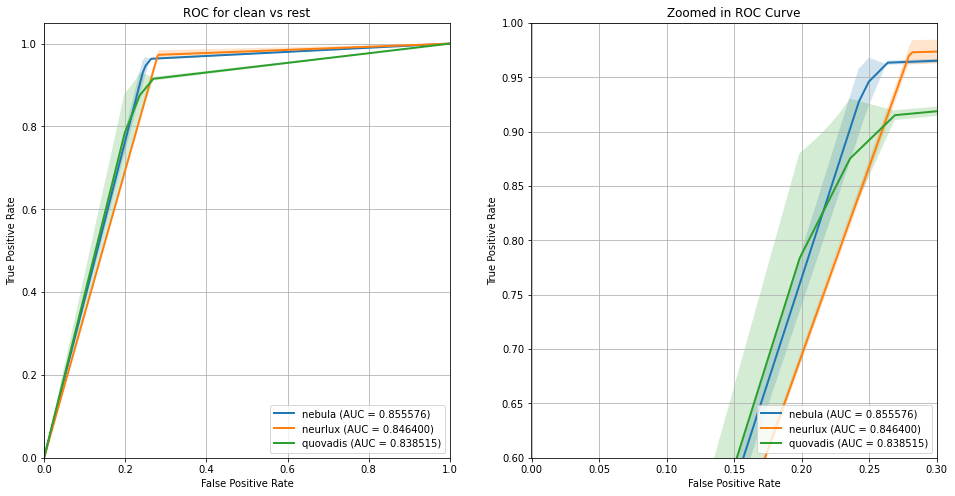

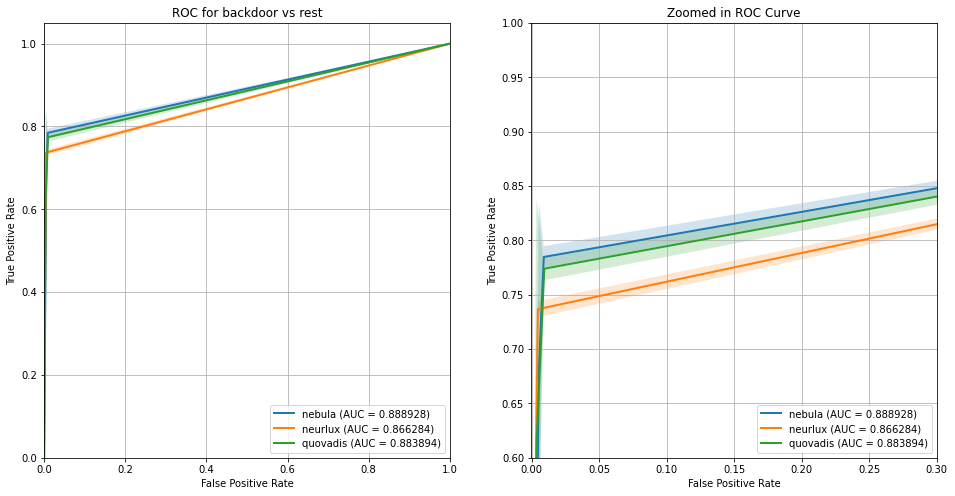

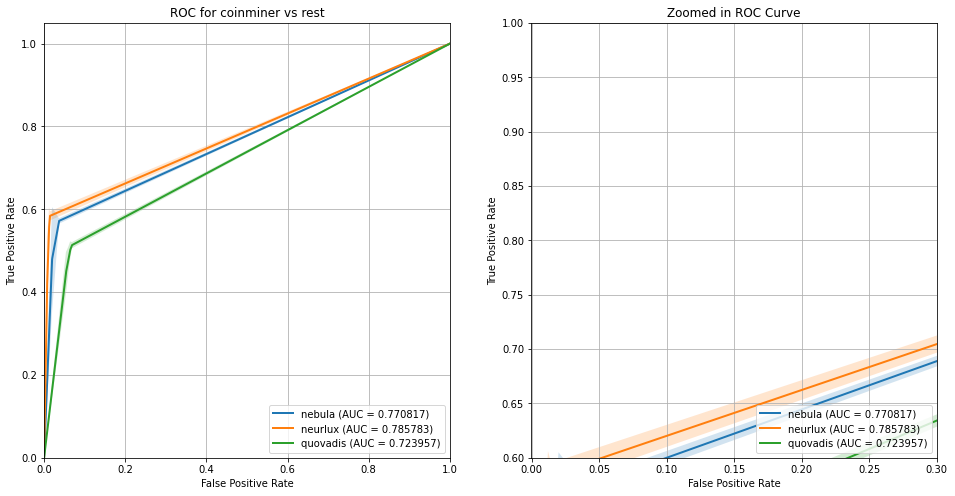

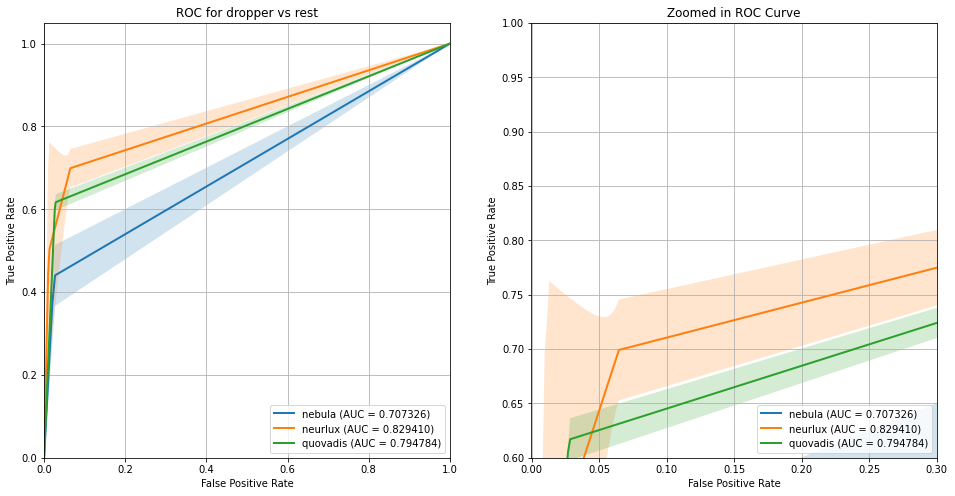

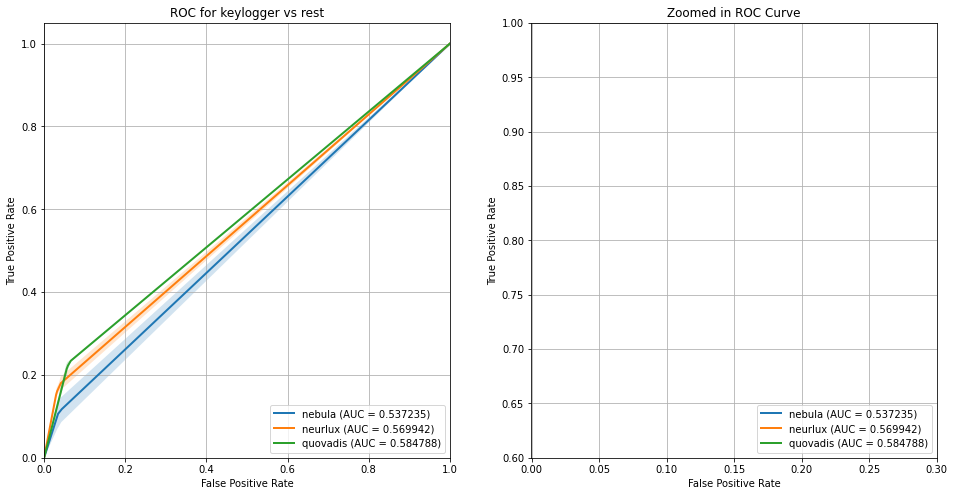

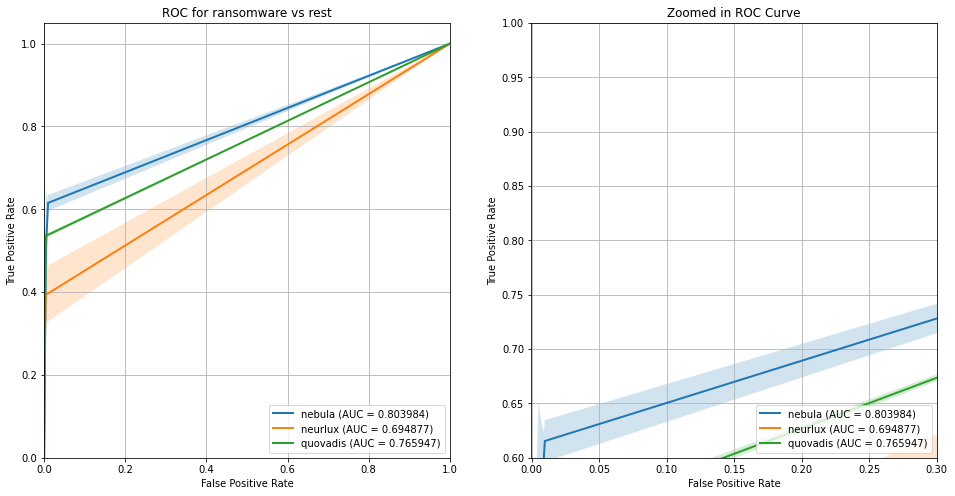

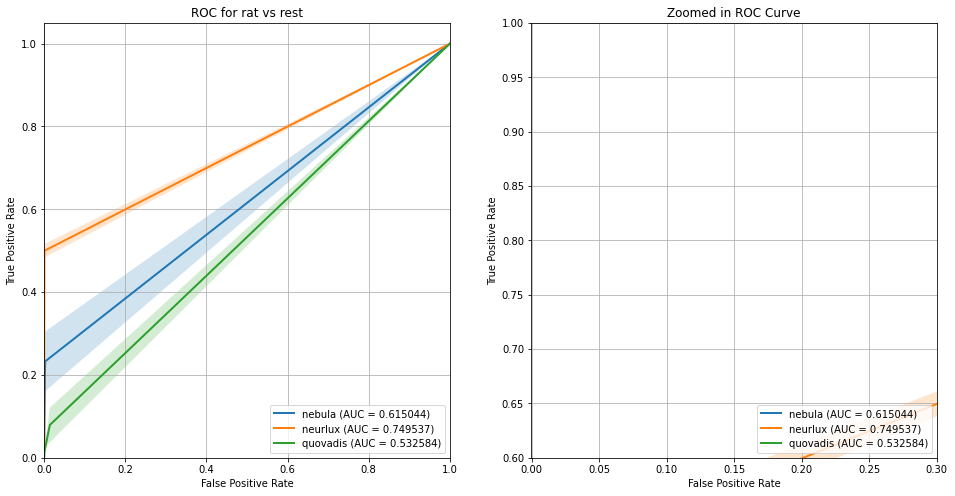

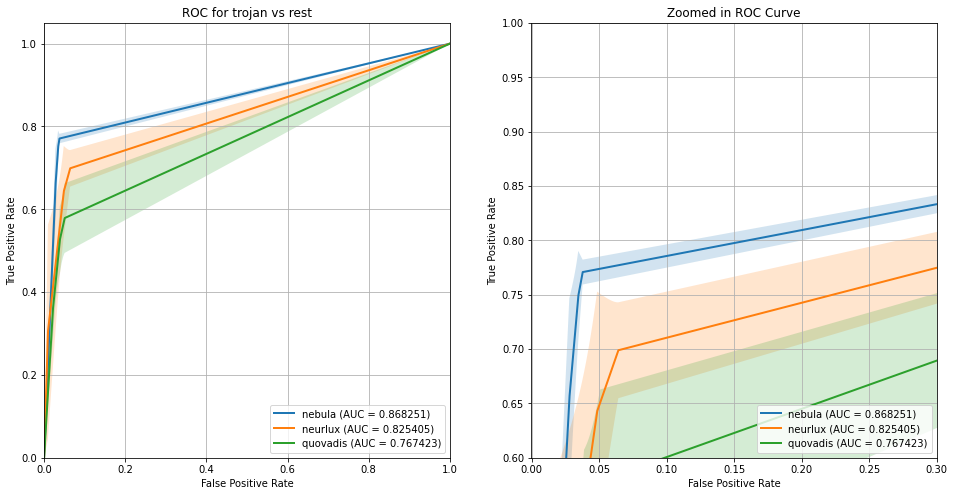

In [6]:
for selected_label in SPEAKEASY_LABELMAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_test.items()}
    base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_label)

    df, axs_test = report_alligned_metrics(
        base_fpr_test,
        tprs_mean_test,
        tprs_std_test,
        metrics_label,
        metrics_full=True
    )
    # suptitle to refer label
    axs_test[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[0:1].tolist() + df.columns[-5:].tolist()])